In [26]:
globals().clear()
## Import libraries
import matplotlib
#matplotlib.use('TkAgg') # Required to make it run on both Windows and Mac
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
import numpy as np 
import os
from tqdm import trange

# Switch of unnecessary TF warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [37]:
gamma = tf.constant(2.0)           # Curvature of the utility function
rho   = tf.constant(0.04)          # Discount rate
A      = tf.constant(0.5)          # TFP
alpha = tf.constant(0.36)          # Returns to scale
delta = tf.constant(0.05)          # Depreciation Rate of Capital

batchSize = 100                    # Batch Size
number_epochs = 500000             # Number of epochs

kMin = 0.1                         # lower bound of sample interval
kMax = 10.0                        # upper bound of sample interval

gridSize = 10000                  # Plotting grid

# Set global seed
tf.random.set_seed(1234)
np.random.seed(1234)

# Value function initial guess
initGuess = -60

# Neural network optimizer
optimizer = keras.optimizers.Adam()

In [38]:
def valueFnNeuralNet(nHidden = 3, nNeurons = 8):
	model = keras.models.Sequential()

	# Input layer
	model.add(keras.layers.Dense(nNeurons, activation = "tanh", input_dim = 1))

	# Hiden layers
	for layer in range(nHidden - 1):
		model.add(keras.layers.Dense(nNeurons, activation = "tanh"))

	# Output layer
	model.add(keras.layers.Dense(1,bias_initializer = keras.initializers.Constant(value = initGuess)))
	return model

def HJB(input, V):
	VPrime = tf.gradients(V(input), input)[0]
	VPrimemax = tf.maximum(VPrime, 1E-7)		# dV/dk

	Y = A * tf.pow(input, alpha)				# Output

	C = tf.pow(VPrimemax, (-1/gamma))			# Consumption

	I = Y - C 									# Investment

	muK = I - delta * input  					# Capital drift

	U = tf.pow(C, 1-gamma) / (1-gamma) 			# Utility

	HJB = U - rho * V(input) + tf.multiply(tf.stop_gradient(VPrimemax), muK)
	return HJB 

def Objective(batchSize):
	input = tf.random.uniform(shape = (batchSize,1), minval = kMin, maxval = kMax)
	error = HJB(input, VF)
	return tf.reduce_mean(tf.square(error))

In [39]:
@tf.function
def training_step():
	with tf.GradientTape() as tape:
		loss = Objective(batchSize)
	grads = tape.gradient(loss, theta)
	optimizer.apply_gradients(zip(grads, theta))
	return loss

In [40]:
def train_model(epochs):
	losses = []
	for epoch in trange(epochs):
		loss = training_step()
		losses.append(loss.numpy())
	return losses 

In [41]:
# Set up neural network
VF = valueFnNeuralNet()

# Define trainable network parameters
theta = VF.trainable_variables

# Run Model (and output loss evolution) 
results = train_model(number_epochs)

100%|██████████| 500000/500000 [02:43<00:00, 3067.01it/s]


In [42]:
@tf.function 	# need decorator since tf.gradients only work in graph mode
def C(input, V):
	VPrime = tf.gradients(V(input), input)[0]
	VPrimemax = tf.maximum(VPrime, 1E-7)
	C = tf.pow(VPrimemax, (-1/gamma))
	return C

# Define plotting grid
K = tf.cast(np.linspace(kMin, kMax, gridSize).reshape(gridSize, 1), tf.float32)

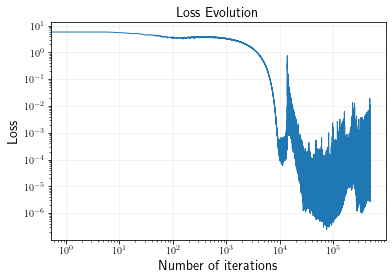

In [43]:


# Import reference results
#reference_V = np.genfromtxt('BEN_V.csv')
#reference_C = np.genfromtxt('BEN_C.csv')

#os.mkdir('results_closed_form_with_reference')
#os.chdir('results_closed_form_with_reference')

matplotlib.rcParams.update({'legend.fontsize': 15, 'axes.labelsize': 14, 'axes.titlesize': 14})
# Plot loss function (as sqrt)
fig = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.plot(results, linewidth=1.0)
plt.grid(alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()
#fig.savefig('Loss.png')

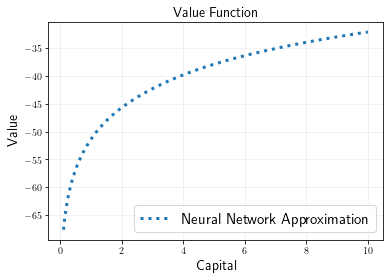

In [45]:
fig = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.plot(K, VF(K), color = "tab:blue", label = "Neural Network Approximation", linewidth = 3, linestyle=':')
#plt.plot(K, reference_V, color= "tab:orange", label = "Finite Difference Scheme", linewidth = 3, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
plt.grid(alpha=0.2)
plt.xlabel('Capital')
plt.ylabel('Value')
plt.title('Value Function')
plt.legend(loc = "lower right")
plt.show()
#fig.savefig('Value.png')

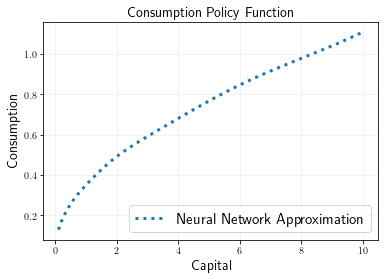

In [46]:
# Plot consumption policy function
fig = plt.figure()
C = C(K, VF)
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif', serif = 'Computer Modern Sans serif')
plt.plot(K, C.numpy(), color = "tab:blue", label = "Neural Network Approximation", linewidth = 3, linestyle=':')
#plt.plot(K, reference_C, color= "tab:orange", label = "Finite Difference Scheme", linewidth = 3, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
plt.grid(alpha=0.2)
plt.xlabel('Capital')
plt.ylabel('Consumption')
plt.title('Consumption Policy Function')
plt.legend(loc = "lower right")
plt.show()
#fig.savefig('Consumption.png')